# 反向传播算法实战

我们将实现一个 4 层的全连接网络，来完成二分类任务。网络输入节点数为 2，隐藏 层的节点数设计为：25、50和25，输出层两个节点，分别表示属于类别 1 的概率和类别 2 的概率，如下图所示。这里并没有采用 Softmax 函数将网络输出概率值之和进行约束， 而是直接利用均方误差函数计算与 One-hot 编码的真实标签之间的误差，所有的网络激活 函数全部采用 Sigmoid 函数，这些设计都是为了能直接利用我们的梯度传播公式。 

![](https://i.postimg.cc/4dypfbvF/screenshot-24.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

### 1. 准备数据

In [2]:
X, y = datasets.make_moons(n_samples=2000, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X.shape, y.shape)

(2000, 2) (2000,)


In [3]:
def make_plot(X, y, plot_name):
    plt.figure(figsize=(16, 12))    
    plt.title(plot_name, fontsize=30)     
    plt.scatter(X[y==0, 0], X[y==0, 1])
    plt.scatter(X[y==1, 0], X[y==1, 1])

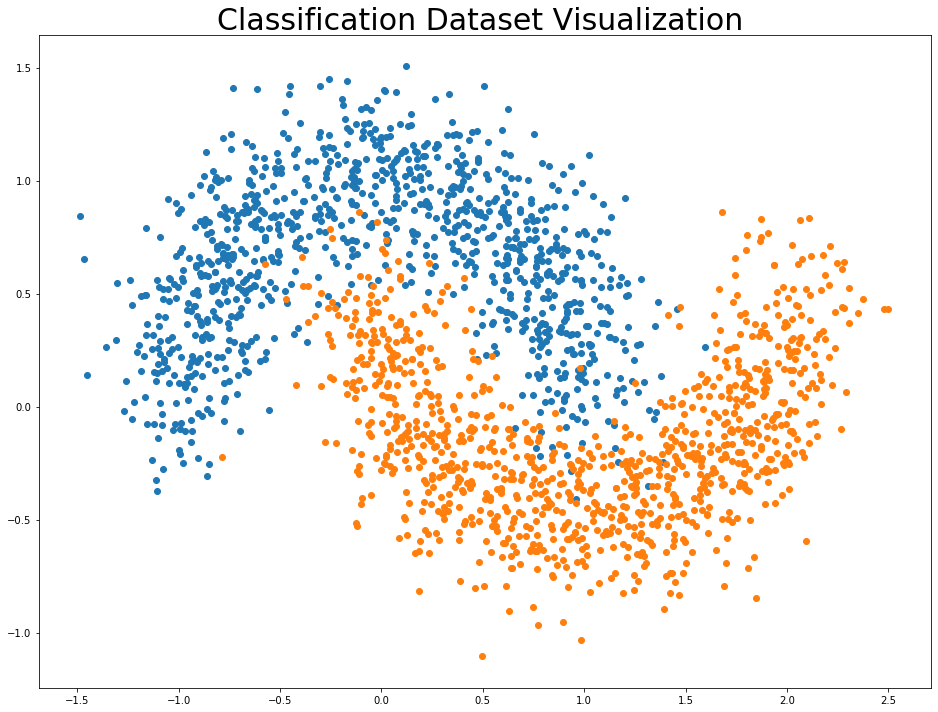

In [4]:
make_plot(X, y, "Classification Dataset Visualization ") 

### 2. 网络层
- 通过新建类 `Layer` 实现一个网络层，需要传入网络层的输入节点数、输出节点数、激 活函数类型等参数
- 权值 `weights` 和偏置张量 `bias` 在初始化时根据输入、输出节点数自动 生成并初始化

In [5]:
class Layer:
    # 全链接网络层
    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        """
        :param int n_input: 输入节点数 
        :param int n_neurons: 输出节点数         
        :param str activation: 激活函数类型         
        :param weights: 权值张量，默认类内部生成         
        :param bias: 偏置，默认类内部生成 
        """
        self.weights = weights if weights is not None else np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons) 
        self.bias = bias if bias is not None else np.random.rand(n_neurons) * 0.1
        self.activation = activation # 激活函数类型，如’sigmoid’         
        self.last_activation = None # 激活函数的输出值 o         
        self.error = None  # 用于计算当前层的 delta 变量的中间变量 
        self.delta = None  # 记录当前层的 delta 变量，用于计算梯度 
    
    def activate(self, x):
        # 前向计算函数
        r = np.dot(x, self.weights) + self.bias # X@W + b
        # 通过激活函数，得到全连接层的输出 o (last_activation)      
        self.last_activation = self._apply_activation(r) 
        return self.last_activation
    
    def _apply_activation(self, r): # 计算激活函数的输出
        if self.activation is None:
            return r # 无激活函数，直接返回
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        
        return r
    
    def apply_activation_derivative(self, r):
        # 计算激活函数的导数
        # 无激活函数， 导数为 1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU 函数的导数
        elif self.activation == 'relu':             
            grad = np.array(r, copy=True)             
            grad[r > 0] = 1.             
            grad[r <= 0] = 0.             
            return grad
        # tanh 函数的导数实现         
        elif self.activation == 'tanh':             
            return 1 - r ** 2 
        # Sigmoid 函数的导数实现         
        elif self.activation == 'sigmoid': 
            return r * (1 - r)
        return r

### 3. 网络模型
- 创建单层网络类后，我们实现网络模型的 `NeuralNetwork` 类
- 它内部维护各层的网络 层 `Layer` 类对象，可以通过 `add_layer` 函数追加网络层，
- 实现创建不同结构的网络模型目 的。

In [6]:
y_test.flatten().shape

(600,)

In [39]:
class NeuralNetwork:
    def __init__(self):
        self._layers = [] # 网络层对象列表
    
    def add_layer(self, layer):
        self._layers.append(layer)
    
    def feed_farword(self, X):
        # 前向传播
        for layer in self._layers:
            X = layer.activate(X)
        return X
    
    def backpropagation(self, X, y, learning_rate):
        # 反向传播算法实现
        # 向前计算，得到输出值
        output = self.feed_farword(X)
        for i in reversed(range(len(self._layers))): # 反向循环
            layer = self._layers[i]
            if layer == self._layers[-1]: # 如果是输出层
                layer.error = y - output
                # 计算最后一层的 delta，参考输出层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else: # 如果是隐藏层
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error*layer.apply_activation_derivative(layer.last_activation)
        
        # 循环更新权值
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i 为上一网络层的输出
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
            # 梯度下降算法，delta 是公式中的负数，故这里用加号 
            layer.weights += layer.delta * o_i.T * learning_rate 
    
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        # 网络训练函数
        # one-hot 编码
        y_onehot = np.zeros((y_train.shape[0], 2)) 
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        mses = [] 
        for i in range(max_epochs):  # 训练 100 个 epoch             
            for j in range(len(X_train)):  # 一次训练一个样本                 
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)             
                if i % 10 == 0: 
                    # 打印出 MSE Loss                 
                    mse = np.mean(np.square(y_onehot - self.feed_farword(X_train)))                 
                    mses.append(mse)                 
                    print('Epoch: #%s, MSE: %f, Accuracy: %.2f%%' % 
                          (i, float(mse), self.accuracy(self.predict(X_test), y_test.flatten()) * 100)) 

        return mses
    
    def accuracy(self, y_predict, y_test): # 计算准确度
        return np.sum(y_predict == y_test) / len(y_test)
    
    def predict(self, X_predict):
        y_predict = self.feed_farword(X_predict) # 此时的 y_predict 形状是 [600 * 2]，第二个维度表示两个输出的概率
        y_predict = np.argmax(y_predict, axis=1)
        return y_predict        

### 4. 网络训练

In [40]:
nn = NeuralNetwork() # 实例化网络类 
nn.add_layer(Layer(2, 25, 'sigmoid'))  # 隐藏层 1, 2=>25 
nn.add_layer(Layer(25, 50, 'sigmoid')) # 隐藏层 2, 25=>50 
nn.add_layer(Layer(50, 25, 'sigmoid')) # 隐藏层 3, 50=>25 
nn.add_layer(Layer(25, 2, 'sigmoid'))  # 输出层, 25=>2 

In [41]:
nn.train(X_train, X_test, y_train, y_test, learning_rate=0.01, max_epochs=100)

Epoch: #0, MSE: 0.461128
Accuracy: 49.50%
Epoch: #0, MSE: 0.461135
Accuracy: 49.50%
Epoch: #0, MSE: 0.460757
Accuracy: 49.50%
Epoch: #0, MSE: 0.460372
Accuracy: 49.50%
Epoch: #0, MSE: 0.460381
Accuracy: 49.50%
Epoch: #0, MSE: 0.459990
Accuracy: 49.50%
Epoch: #0, MSE: 0.459590
Accuracy: 49.50%
Epoch: #0, MSE: 0.459600
Accuracy: 49.50%
Epoch: #0, MSE: 0.459192
Accuracy: 49.50%
Epoch: #0, MSE: 0.458777
Accuracy: 49.50%
Epoch: #0, MSE: 0.458789
Accuracy: 49.50%
Epoch: #0, MSE: 0.458801
Accuracy: 49.50%
Epoch: #0, MSE: 0.458812
Accuracy: 49.50%
Epoch: #0, MSE: 0.458391
Accuracy: 49.50%
Epoch: #0, MSE: 0.457962
Accuracy: 49.50%
Epoch: #0, MSE: 0.457976
Accuracy: 49.50%
Epoch: #0, MSE: 0.457534
Accuracy: 49.50%
Epoch: #0, MSE: 0.457549
Accuracy: 49.50%
Epoch: #0, MSE: 0.457563
Accuracy: 49.50%
Epoch: #0, MSE: 0.457577
Accuracy: 49.50%
Epoch: #0, MSE: 0.457132
Accuracy: 49.50%
Epoch: #0, MSE: 0.457147
Accuracy: 49.50%
Epoch: #0, MSE: 0.457162
Accuracy: 49.50%
Epoch: #0, MSE: 0.457177
Accuracy:

Epoch: #0, MSE: 0.381955
Accuracy: 49.50%
Epoch: #0, MSE: 0.382480
Accuracy: 49.50%
Epoch: #0, MSE: 0.381236
Accuracy: 49.50%
Epoch: #0, MSE: 0.381764
Accuracy: 49.50%
Epoch: #0, MSE: 0.382290
Accuracy: 49.50%
Epoch: #0, MSE: 0.381048
Accuracy: 49.50%
Epoch: #0, MSE: 0.381575
Accuracy: 49.50%
Epoch: #0, MSE: 0.380350
Accuracy: 49.50%
Epoch: #0, MSE: 0.380880
Accuracy: 49.50%
Epoch: #0, MSE: 0.381410
Accuracy: 49.50%
Epoch: #0, MSE: 0.381936
Accuracy: 49.50%
Epoch: #0, MSE: 0.380703
Accuracy: 49.50%
Epoch: #0, MSE: 0.381228
Accuracy: 49.50%
Epoch: #0, MSE: 0.381755
Accuracy: 49.50%
Epoch: #0, MSE: 0.380524
Accuracy: 49.50%
Epoch: #0, MSE: 0.381054
Accuracy: 49.50%
Epoch: #0, MSE: 0.379837
Accuracy: 49.50%
Epoch: #0, MSE: 0.380365
Accuracy: 49.50%
Epoch: #0, MSE: 0.379167
Accuracy: 49.50%
Epoch: #0, MSE: 0.379699
Accuracy: 49.50%
Epoch: #0, MSE: 0.378517
Accuracy: 49.50%
Epoch: #0, MSE: 0.379049
Accuracy: 49.50%
Epoch: #0, MSE: 0.377885
Accuracy: 49.50%
Epoch: #0, MSE: 0.378420
Accuracy:

Accuracy: 49.50%
Epoch: #0, MSE: 0.363224
Accuracy: 49.50%
Epoch: #0, MSE: 0.363599
Accuracy: 49.50%
Epoch: #0, MSE: 0.363009
Accuracy: 49.50%
Epoch: #0, MSE: 0.362455
Accuracy: 49.50%
Epoch: #0, MSE: 0.362810
Accuracy: 49.50%
Epoch: #0, MSE: 0.363177
Accuracy: 49.50%
Epoch: #0, MSE: 0.362607
Accuracy: 49.50%
Epoch: #0, MSE: 0.362075
Accuracy: 49.50%
Epoch: #0, MSE: 0.361579
Accuracy: 49.50%
Epoch: #0, MSE: 0.361905
Accuracy: 49.50%
Epoch: #0, MSE: 0.361420
Accuracy: 49.50%
Epoch: #0, MSE: 0.360972
Accuracy: 49.50%
Epoch: #0, MSE: 0.361272
Accuracy: 49.50%
Epoch: #0, MSE: 0.360834
Accuracy: 49.50%
Epoch: #0, MSE: 0.361128
Accuracy: 49.50%
Epoch: #0, MSE: 0.361439
Accuracy: 49.50%
Epoch: #0, MSE: 0.361764
Accuracy: 49.50%
Epoch: #0, MSE: 0.361277
Accuracy: 49.50%
Epoch: #0, MSE: 0.360826
Accuracy: 49.50%
Epoch: #0, MSE: 0.361127
Accuracy: 49.50%
Epoch: #0, MSE: 0.361443
Accuracy: 49.50%
Epoch: #0, MSE: 0.361774
Accuracy: 49.50%
Epoch: #0, MSE: 0.362118
Accuracy: 49.50%
Epoch: #0, MSE: 0

Epoch: #0, MSE: 0.354439
Accuracy: 49.50%
Epoch: #0, MSE: 0.354003
Accuracy: 49.50%
Epoch: #0, MSE: 0.354270
Accuracy: 49.50%
Epoch: #0, MSE: 0.354552
Accuracy: 49.50%
Epoch: #0, MSE: 0.354851
Accuracy: 49.50%
Epoch: #0, MSE: 0.354368
Accuracy: 49.50%
Epoch: #0, MSE: 0.354661
Accuracy: 49.50%
Epoch: #0, MSE: 0.354970
Accuracy: 49.50%
Epoch: #0, MSE: 0.354468
Accuracy: 49.50%
Epoch: #0, MSE: 0.354772
Accuracy: 49.50%
Epoch: #0, MSE: 0.355090
Accuracy: 49.50%
Epoch: #0, MSE: 0.354569
Accuracy: 49.50%
Epoch: #0, MSE: 0.354882
Accuracy: 49.50%
Epoch: #0, MSE: 0.354370
Accuracy: 49.50%
Epoch: #0, MSE: 0.353893
Accuracy: 49.50%
Epoch: #0, MSE: 0.353452
Accuracy: 49.50%
Epoch: #0, MSE: 0.353719
Accuracy: 49.50%
Epoch: #0, MSE: 0.353285
Accuracy: 49.50%
Epoch: #0, MSE: 0.353548
Accuracy: 49.50%
Epoch: #0, MSE: 0.353828
Accuracy: 49.50%
Epoch: #0, MSE: 0.354123
Accuracy: 49.50%
Epoch: #0, MSE: 0.353640
Accuracy: 49.50%
Epoch: #0, MSE: 0.353193
Accuracy: 49.50%
Epoch: #0, MSE: 0.352780
Accuracy:

Epoch: #0, MSE: 0.335942
Accuracy: 49.50%
Epoch: #0, MSE: 0.335562
Accuracy: 49.50%
Epoch: #0, MSE: 0.335222
Accuracy: 49.50%
Epoch: #0, MSE: 0.334922
Accuracy: 49.50%
Epoch: #0, MSE: 0.334660
Accuracy: 49.50%
Epoch: #0, MSE: 0.334438
Accuracy: 49.50%
Epoch: #0, MSE: 0.334251
Accuracy: 49.50%
Epoch: #0, MSE: 0.334163
Accuracy: 49.50%
Epoch: #0, MSE: 0.333982
Accuracy: 49.50%
Epoch: #0, MSE: 0.333837
Accuracy: 49.50%
Epoch: #0, MSE: 0.333716
Accuracy: 49.50%
Epoch: #0, MSE: 0.333616
Accuracy: 49.50%
Epoch: #0, MSE: 0.333445
Accuracy: 49.50%
Epoch: #0, MSE: 0.333308
Accuracy: 49.50%
Epoch: #0, MSE: 0.333175
Accuracy: 49.50%
Epoch: #0, MSE: 0.333042
Accuracy: 49.50%
Epoch: #0, MSE: 0.332904
Accuracy: 49.50%
Epoch: #0, MSE: 0.332787
Accuracy: 49.50%
Epoch: #0, MSE: 0.332628
Accuracy: 49.50%
Epoch: #0, MSE: 0.332504
Accuracy: 49.50%
Epoch: #0, MSE: 0.332413
Accuracy: 49.50%
Epoch: #0, MSE: 0.332355
Accuracy: 49.50%
Epoch: #0, MSE: 0.332150
Accuracy: 49.50%
Epoch: #0, MSE: 0.331968
Accuracy:

Accuracy: 49.50%
Epoch: #0, MSE: 0.300683
Accuracy: 49.50%
Epoch: #0, MSE: 0.299984
Accuracy: 49.50%
Epoch: #0, MSE: 0.299308
Accuracy: 49.50%
Epoch: #0, MSE: 0.298656
Accuracy: 49.50%
Epoch: #0, MSE: 0.298027
Accuracy: 49.50%
Epoch: #0, MSE: 0.298195
Accuracy: 49.50%
Epoch: #0, MSE: 0.297563
Accuracy: 49.50%
Epoch: #0, MSE: 0.296954
Accuracy: 49.50%
Epoch: #0, MSE: 0.297102
Accuracy: 49.50%
Epoch: #0, MSE: 0.297273
Accuracy: 49.50%
Epoch: #0, MSE: 0.296636
Accuracy: 49.50%
Epoch: #0, MSE: 0.296808
Accuracy: 49.50%
Epoch: #0, MSE: 0.296171
Accuracy: 49.50%
Epoch: #0, MSE: 0.295555
Accuracy: 49.50%
Epoch: #0, MSE: 0.295708
Accuracy: 49.50%
Epoch: #0, MSE: 0.295090
Accuracy: 49.50%
Epoch: #0, MSE: 0.294493
Accuracy: 49.50%
Epoch: #0, MSE: 0.293918
Accuracy: 49.50%
Epoch: #0, MSE: 0.293362
Accuracy: 49.50%
Epoch: #0, MSE: 0.293450
Accuracy: 49.50%
Epoch: #0, MSE: 0.292891
Accuracy: 49.50%
Epoch: #0, MSE: 0.292982
Accuracy: 49.50%
Epoch: #0, MSE: 0.293100
Accuracy: 49.50%
Epoch: #0, MSE: 0

Epoch: #0, MSE: 0.256793
Accuracy: 49.50%
Epoch: #0, MSE: 0.256506
Accuracy: 49.50%
Epoch: #0, MSE: 0.256644
Accuracy: 49.50%
Epoch: #0, MSE: 0.256805
Accuracy: 49.50%
Epoch: #0, MSE: 0.256495
Accuracy: 49.50%
Epoch: #0, MSE: 0.256657
Accuracy: 49.50%
Epoch: #0, MSE: 0.256349
Accuracy: 49.50%
Epoch: #0, MSE: 0.256512
Accuracy: 49.50%
Epoch: #0, MSE: 0.256699
Accuracy: 49.50%
Epoch: #0, MSE: 0.256369
Accuracy: 49.50%
Epoch: #0, MSE: 0.256556
Accuracy: 49.50%
Epoch: #0, MSE: 0.256766
Accuracy: 49.50%
Epoch: #0, MSE: 0.256998
Accuracy: 49.50%
Epoch: #0, MSE: 0.257253
Accuracy: 49.50%
Epoch: #0, MSE: 0.257529
Accuracy: 49.50%
Epoch: #0, MSE: 0.257098
Accuracy: 49.50%
Epoch: #0, MSE: 0.256698
Accuracy: 49.50%
Epoch: #0, MSE: 0.256329
Accuracy: 49.50%
Epoch: #0, MSE: 0.255989
Accuracy: 49.50%
Epoch: #0, MSE: 0.255678
Accuracy: 49.50%
Epoch: #0, MSE: 0.255860
Accuracy: 49.50%
Epoch: #0, MSE: 0.255551
Accuracy: 49.50%
Epoch: #0, MSE: 0.255271
Accuracy: 49.50%
Epoch: #0, MSE: 0.255429
Accuracy:

Accuracy: 79.83%
Epoch: #10, MSE: 0.239613
Accuracy: 79.33%
Epoch: #10, MSE: 0.239639
Accuracy: 79.83%
Epoch: #10, MSE: 0.239613
Accuracy: 79.33%
Epoch: #10, MSE: 0.239621
Accuracy: 80.33%
Epoch: #10, MSE: 0.239656
Accuracy: 81.00%
Epoch: #10, MSE: 0.239733
Accuracy: 80.67%
Epoch: #10, MSE: 0.239654
Accuracy: 81.00%
Epoch: #10, MSE: 0.239729
Accuracy: 80.83%
Epoch: #10, MSE: 0.239841
Accuracy: 78.50%
Epoch: #10, MSE: 0.239727
Accuracy: 80.67%
Epoch: #10, MSE: 0.239647
Accuracy: 81.00%
Epoch: #10, MSE: 0.239727
Accuracy: 80.50%
Epoch: #10, MSE: 0.239825
Accuracy: 79.17%
Epoch: #10, MSE: 0.239950
Accuracy: 73.33%
Epoch: #10, MSE: 0.239804
Accuracy: 79.17%
Epoch: #10, MSE: 0.239696
Accuracy: 80.67%
Epoch: #10, MSE: 0.239800
Accuracy: 79.17%
Epoch: #10, MSE: 0.239694
Accuracy: 81.00%
Epoch: #10, MSE: 0.239795
Accuracy: 79.33%
Epoch: #10, MSE: 0.239689
Accuracy: 80.83%
Epoch: #10, MSE: 0.239785
Accuracy: 79.17%
Epoch: #10, MSE: 0.239681
Accuracy: 80.67%
Epoch: #10, MSE: 0.239768
Accuracy: 7

Epoch: #10, MSE: 0.242123
Accuracy: 50.50%
Epoch: #10, MSE: 0.242477
Accuracy: 50.50%
Epoch: #10, MSE: 0.241994
Accuracy: 50.50%
Epoch: #10, MSE: 0.242363
Accuracy: 50.50%
Epoch: #10, MSE: 0.241886
Accuracy: 50.50%
Epoch: #10, MSE: 0.241440
Accuracy: 50.50%
Epoch: #10, MSE: 0.241036
Accuracy: 50.50%
Epoch: #10, MSE: 0.240683
Accuracy: 50.50%
Epoch: #10, MSE: 0.240368
Accuracy: 50.50%
Epoch: #10, MSE: 0.240626
Accuracy: 50.50%
Epoch: #10, MSE: 0.240908
Accuracy: 50.50%
Epoch: #10, MSE: 0.240566
Accuracy: 50.50%
Epoch: #10, MSE: 0.240261
Accuracy: 50.50%
Epoch: #10, MSE: 0.239993
Accuracy: 53.50%
Epoch: #10, MSE: 0.240229
Accuracy: 50.50%
Epoch: #10, MSE: 0.240475
Accuracy: 50.50%
Epoch: #10, MSE: 0.240764
Accuracy: 50.50%
Epoch: #10, MSE: 0.241073
Accuracy: 50.50%
Epoch: #10, MSE: 0.241396
Accuracy: 50.50%
Epoch: #10, MSE: 0.241005
Accuracy: 50.50%
Epoch: #10, MSE: 0.240655
Accuracy: 50.50%
Epoch: #10, MSE: 0.240341
Accuracy: 50.50%
Epoch: #10, MSE: 0.240065
Accuracy: 51.33%
Epoch: #10,

Accuracy: 80.50%
Epoch: #10, MSE: 0.238770
Accuracy: 80.67%
Epoch: #10, MSE: 0.238861
Accuracy: 79.83%
Epoch: #10, MSE: 0.238995
Accuracy: 78.33%
Epoch: #10, MSE: 0.239146
Accuracy: 73.00%
Epoch: #10, MSE: 0.238970
Accuracy: 78.50%
Epoch: #10, MSE: 0.239132
Accuracy: 73.33%
Epoch: #10, MSE: 0.238955
Accuracy: 79.17%
Epoch: #10, MSE: 0.239098
Accuracy: 74.17%
Epoch: #10, MSE: 0.239265
Accuracy: 66.33%
Epoch: #10, MSE: 0.239063
Accuracy: 75.17%
Epoch: #10, MSE: 0.239227
Accuracy: 67.67%
Epoch: #10, MSE: 0.239032
Accuracy: 75.33%
Epoch: #10, MSE: 0.238870
Accuracy: 79.50%
Epoch: #10, MSE: 0.239000
Accuracy: 76.17%
Epoch: #10, MSE: 0.238844
Accuracy: 79.67%
Epoch: #10, MSE: 0.238970
Accuracy: 76.83%
Epoch: #10, MSE: 0.239126
Accuracy: 71.33%
Epoch: #10, MSE: 0.239317
Accuracy: 62.00%
Epoch: #10, MSE: 0.239546
Accuracy: 53.67%
Epoch: #10, MSE: 0.239814
Accuracy: 50.50%
Epoch: #10, MSE: 0.239526
Accuracy: 54.33%
Epoch: #10, MSE: 0.239274
Accuracy: 63.00%
Epoch: #10, MSE: 0.239473
Accuracy: 5

Epoch: #10, MSE: 0.238245
Accuracy: 80.67%
Epoch: #10, MSE: 0.238320
Accuracy: 80.67%
Epoch: #10, MSE: 0.238228
Accuracy: 81.00%
Epoch: #10, MSE: 0.238301
Accuracy: 80.67%
Epoch: #10, MSE: 0.238416
Accuracy: 80.00%
Epoch: #10, MSE: 0.238557
Accuracy: 78.00%
Epoch: #10, MSE: 0.238399
Accuracy: 80.00%
Epoch: #10, MSE: 0.238530
Accuracy: 78.33%
Epoch: #10, MSE: 0.238374
Accuracy: 80.17%
Epoch: #10, MSE: 0.238257
Accuracy: 80.83%
Epoch: #10, MSE: 0.238176
Accuracy: 80.83%
Epoch: #10, MSE: 0.238131
Accuracy: 79.50%
Epoch: #10, MSE: 0.238128
Accuracy: 79.83%
Epoch: #10, MSE: 0.238132
Accuracy: 79.50%
Epoch: #10, MSE: 0.238122
Accuracy: 79.83%
Epoch: #10, MSE: 0.238128
Accuracy: 79.67%
Epoch: #10, MSE: 0.238161
Accuracy: 80.83%
Epoch: #10, MSE: 0.238116
Accuracy: 79.67%
Epoch: #10, MSE: 0.238103
Accuracy: 79.17%
Epoch: #10, MSE: 0.238126
Accuracy: 79.33%
Epoch: #10, MSE: 0.238103
Accuracy: 79.50%
Epoch: #10, MSE: 0.238120
Accuracy: 80.00%
Epoch: #10, MSE: 0.238093
Accuracy: 79.33%
Epoch: #10,

Epoch: #10, MSE: 0.237497
Accuracy: 79.33%
Epoch: #10, MSE: 0.237529
Accuracy: 79.50%
Epoch: #10, MSE: 0.237497
Accuracy: 79.33%
Epoch: #10, MSE: 0.237528
Accuracy: 79.67%
Epoch: #10, MSE: 0.237581
Accuracy: 78.67%
Epoch: #10, MSE: 0.237515
Accuracy: 79.67%
Epoch: #10, MSE: 0.237574
Accuracy: 78.50%
Epoch: #10, MSE: 0.237652
Accuracy: 77.67%
Epoch: #10, MSE: 0.237555
Accuracy: 79.00%
Epoch: #10, MSE: 0.237496
Accuracy: 79.83%
Epoch: #10, MSE: 0.237541
Accuracy: 79.17%
Epoch: #10, MSE: 0.237611
Accuracy: 77.83%
Epoch: #10, MSE: 0.237521
Accuracy: 79.33%
Epoch: #10, MSE: 0.237594
Accuracy: 78.33%
Epoch: #10, MSE: 0.237509
Accuracy: 79.67%
Epoch: #10, MSE: 0.237460
Accuracy: 79.33%
Epoch: #10, MSE: 0.237504
Accuracy: 79.67%
Epoch: #10, MSE: 0.237574
Accuracy: 78.50%
Epoch: #10, MSE: 0.237671
Accuracy: 75.17%
Epoch: #10, MSE: 0.237796
Accuracy: 71.17%
Epoch: #10, MSE: 0.237647
Accuracy: 75.33%
Epoch: #10, MSE: 0.237534
Accuracy: 78.50%
Epoch: #10, MSE: 0.237629
Accuracy: 75.83%
Epoch: #10,

KeyboardInterrupt: 

In [13]:
y_predict = nn.predict(X_test)

In [17]:
y_predict[:10, :]

array([[0.02776298, 0.9716734 ],
       [0.94112451, 0.06102209],
       [0.24087036, 0.75816497],
       [0.02608322, 0.97381209],
       [0.8090253 , 0.18627996],
       [0.94397072, 0.05680068],
       [0.97770546, 0.02329572],
       [0.1375391 , 0.85889361],
       [0.38609147, 0.60775342],
       [0.90227796, 0.100444  ]])

In [15]:
y_test[:10]

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [24]:
y_predict = np.argmax(y_predict, axis=1)

In [25]:
nn.accuracy(y_predict, y_test.flatten())

0.8916666666666667